In [1]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
import shutil
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight 
import pandas as pd

In [13]:
data_path = pathlib.Path("D:/Aravind/machine learning on coursera/archive/brain_tumor_dataset")
# data_path = os.path.join(data_path, os.listdir(data_path)[2])

## Data Augmentation

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     zoom_range=0.05,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     brightness_range = [0.5, 1.4],
                                     validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory=data_path,
                                                    batch_size=10,
                                                    target_size=(224, 224),
                                                    shuffle = True,
                                                    class_mode = "binary",
                                                    subset = "training")

validation_generator = train_datagen.flow_from_directory(directory=data_path,
                                                            batch_size=10,
                                                            target_size=(224, 224),
                                                            shuffle = False,
                                                            class_mode = "binary",
                                                            subset = "validation")

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## Data Visualization

In [15]:
def plot_categories(training_images, training_labels,mapping = None, count = 10):
  fig, axes = plt.subplots(int(np.sqrt(count))+1, int(np.sqrt(count))+1, figsize=(16, 15))
  axes = axes.flatten()
    
  for ax in axes:
    ax.set_axis_off()

  for k in range(count):
    img = training_images[k]
    img = array_to_img(img)
    ax = axes[k]
    ax.set_axis_on()
    ax.imshow(img, cmap="Greys_r")
    label = None
    if mapping:
        label = mapping[training_labels[k]]
    else:
        label = training_labels[k]
        
    ax.set_title(label)
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

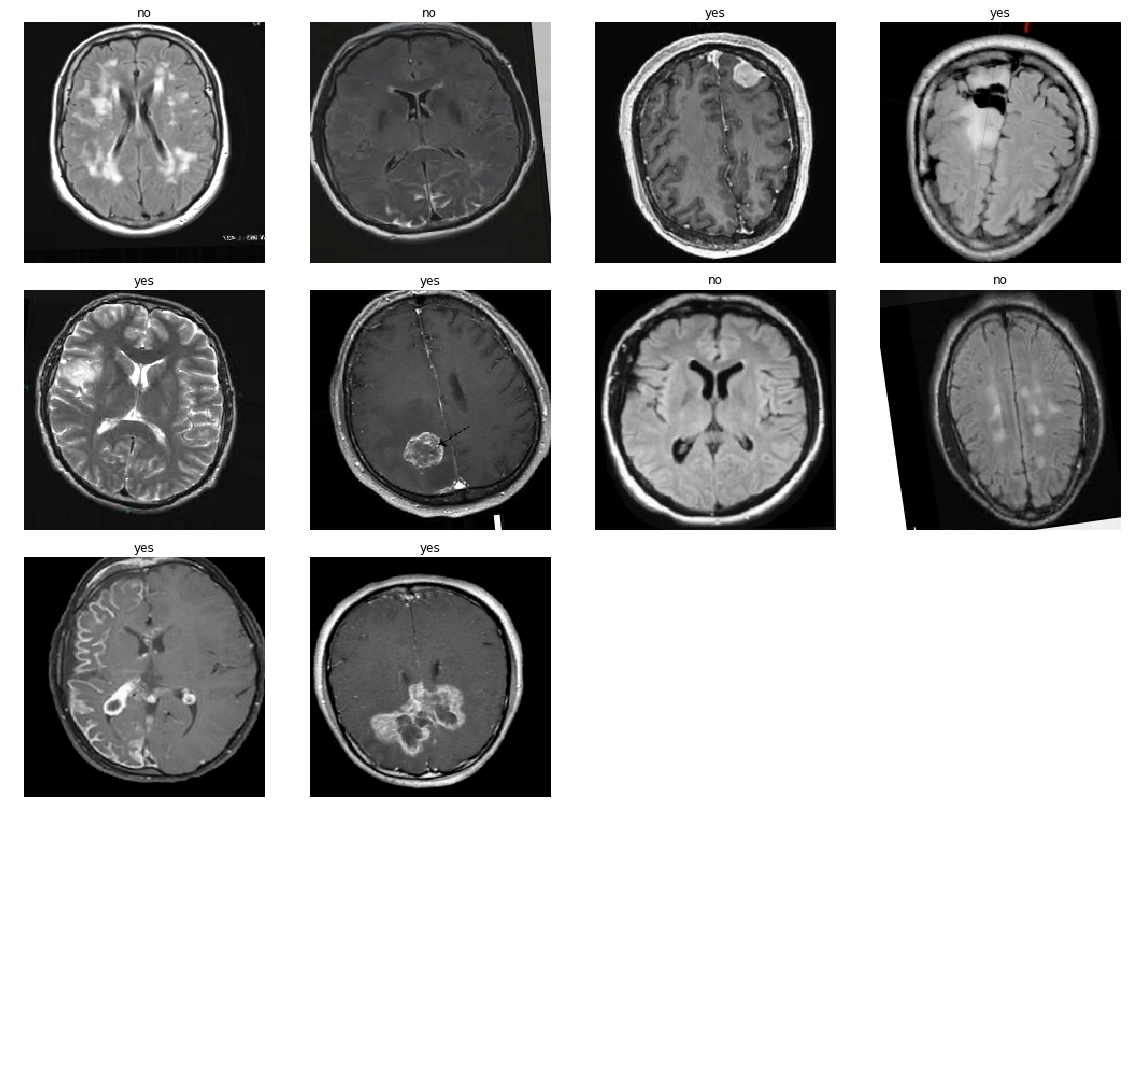

In [16]:
sample_X , sample_y = train_generator.next()
mapping = {1:"yes" , 0:"no"}

plot_categories(sample_X,sample_y,mapping,sample_X.shape[0])

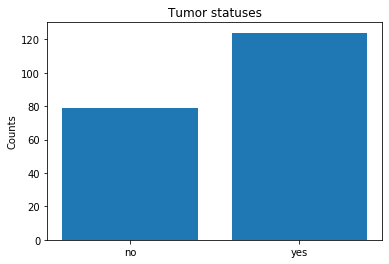

In [17]:
labels, counts = np.unique(train_generator.labels, return_counts = True)
labels = [mapping[l] for l in labels]

fig, ax = plt.subplots()
ax.set_ylabel('Counts')
ax.set_title('Tumor statuses')
ax.bar(labels, counts)

plt.show()

## Processing

In [18]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_generator.classes), train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

In [19]:
metrics = [tf.keras.metrics.TruePositives(name='tp'), tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.FalseNegatives(name='fn'),
           tf.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.AUC(name='prc', curve='PR'),]

##  Model

### Simple CNN Model 

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 512, activation = 'relu'),
    tf.keras.layers.Dropout(rate = 0.5),
    tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
])

In [ ]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0008),
                loss = "binary_crossentropy",
                metrics=metrics)

tf.keras.utils.plot_model(model) # image of models structure you can get from output folder
model.summary()

In [22]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0008),
             loss = "binary_crossentropy",
             metrics=metrics)
tf.keras.utils.plot_model(model)
model.summary()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (M

In [23]:
history1 = model.fit(train_generator,epochs = 20, validation_data = validation_generator, class_weight=train_class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
21/21 [==============================] - 13s 467ms/step - loss: 0.6496 - tp: 86.0000 - fp: 35.0000 - tn: 44.0000 - fn: 38.0000 - accuracy: 0.6404 - precision: 0.7107 - recall: 0.6935 - auc: 0.6850 - prc: 0.7298 - val_loss: 0.6105 - val_tp: 19.0000 - val_fp: 4.0000 - val_tn: 15.0000 - val_fn: 12.0000 - val_accuracy: 0.6800 - val_precision: 0.8261 - val_recall: 0.6129 - val_auc: 0.7759 - val_prc: 0.8605
Epoch 2/20
21/21 [==============================] - 7s 350ms/step - loss: 0.5704 - tp: 83.0000 - fp: 19.0000 - tn: 60.0000 - fn: 41.0000 - accuracy: 0.7044 - precision: 0.8137 - recall: 0.6694 - auc: 0.7794 - prc: 0.8236 - val_loss: 0.6042 - val_tp: 22.0000 - val_fp: 6.0000 - val_tn: 13.0000 - val_fn: 9.0000 - val_accuracy: 0.7000 - val_precision: 0.7857 - val_recall: 0.7097 - val_auc: 0.7581 - val_prc: 0.8573
Epoch 3/20
21/21 [==============

Epoch 20/20
21/21 [==============================] - 8s 364ms/step - loss: 0.4553 - tp: 104.0000 - fp: 16.0000 - tn: 63.0000 - fn: 20.0000 - accuracy: 0.8227 - precision: 0.8667 - recall: 0.8387 - auc: 0.8827 - prc: 0.9125 - val_loss: 0.4471 - val_tp: 27.0000 - val_fp: 5.0000 - val_tn: 14.0000 - val_fn: 4.0000 - val_accuracy: 0.8200 - val_precision: 0.8438 - val_recall: 0.8710 - val_auc: 0.8744 - val_prc: 0.9128


In [24]:
validation_results = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  0.4614356756210327
tp :  27.0
fp :  6.0
tn :  13.0
fn :  4.0
accuracy :  0.800000011920929
precision :  0.8181818127632141
recall :  0.8709677457809448
auc :  0.8590832352638245
prc :  0.8825249671936035


In [25]:
validation_predictions = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions)

NameError: name 'plot_cm' is not defined